# Efficient Training and Nearest-Neighbor Search with Binary Word Vectors
This notebook contains the experimental code for the “Efficient Training and Nearest-Neighbor Search with Binary Word Vectors” (Novotný et al., 2019) paper. We reproduce the results of Bojanowski et al.&nbsp;[1] and add our own results with binarized FastText models described by Courbariaux et al.&nbsp;[2] and Lam&nbsp;[3].

In [1]:
%matplotlib inline
import json

from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# load
df = pd.read_json('results/duration.json')
df = df.astype(float)
# add totals
df = df.append(pd.Series(df.sum(), name='total'))
df = df.T.append(pd.Series(df.T.sum(), name='total')).T
# order rows and columns by totals
df = df.sort_values(by='total', axis=0, ascending=True)
df = df.sort_values(by='total', axis=1, ascending=True)
df = df.drop('total', axis=0)
df = df.drop('total', axis=1)
df = df.append(pd.Series(df.sum(), name='total'))
df = df.T.append(pd.Series(df.T.sum(), name='total')).T
# display
pd.options.display.float_format = '{:,.0f} s'.format
display(df)

,ro,ar,cs,it,es,ru,fr,de,en,total
l2reg,"5,529 s","10,188 s","10,559 s","38,408 s","43,141 s","53,478 s","56,778 s","80,796 s","197,198 s","496,075 s"
none,"5,900 s","10,192 s","10,471 s","37,685 s","42,787 s","54,231 s","55,621 s","80,947 s","198,699 s","496,533 s"
dbc,"14,738 s","27,567 s","27,361 s","103,164 s","115,592 s","138,549 s","154,004 s","211,835 s","537,730 s","1,330,540 s"
total,"26,167 s","47,947 s","48,391 s","179,257 s","201,520 s","246,258 s","266,403 s","373,578 s","933,627 s","2,323,148 s"


**Table 1:** The durations of training FastText models for different languages (columns) and with different regularization methods (rows) using 16 Intel Xeon Gold 6130 CPU cores at 2.10GHz.

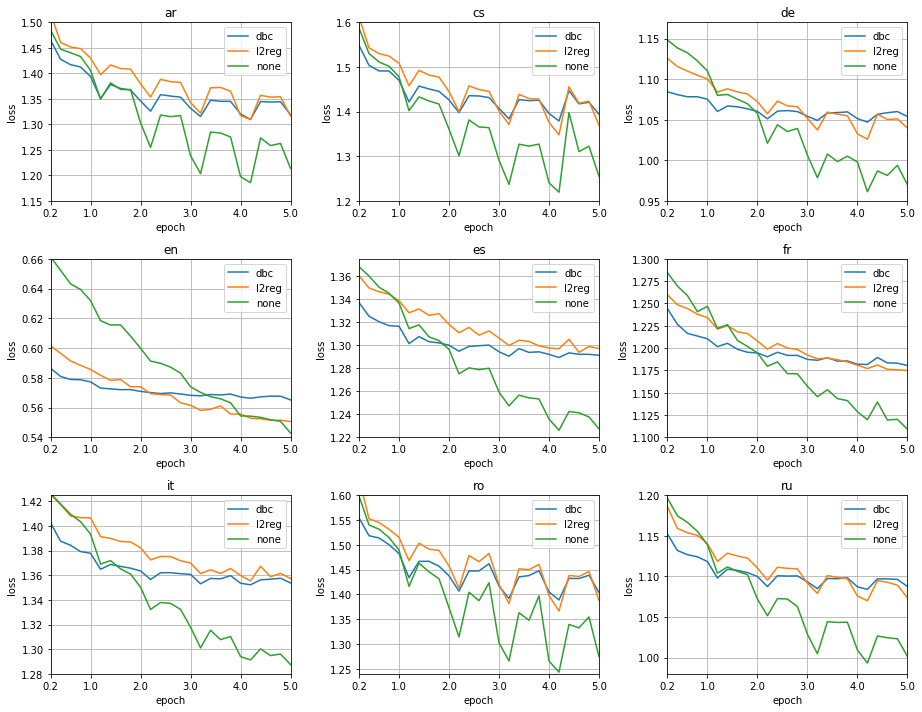

In [3]:
# load
with open('results/loss.json') as f:
    loss = json.load(f)
languages = list(sorted(loss.keys()))
# display
xticks = [0, 4, 9, 14, 19, 24]
ylims = {
    'ar': (1.150, 1.500),
    'cs': (1.200, 1.600),
    'de': (0.950, 1.170),
    'en': (0.540, 0.660),
    'es': (1.220, 1.375),
    'fr': (1.100, 1.300),
    'it': (1.280, 1.425),
    'ro': (1.240, 1.600),
    'ru': (0.980, 1.200),
}
fig = plt.figure(figsize=(13, 10))
for index, language in enumerate(languages):
    ax = fig.add_subplot(3, 3, index + 1)
    df = pd.DataFrame.from_dict(loss[language])
    ax = df.plot(kind='line', grid=True, ax=ax, ylim=ylims[language], title=language)
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_xticks(xticks)
    ax.set_xticklabels([df.index[xtick] for xtick in xticks])
plt.tight_layout()

**Figure 1:** Learning curves of FastText models with different languages and regularization methods.

In [4]:
# load
with open('results/analogy.json') as f:
    analogy = json.load(f)
    accuracies = {}
    durations = {}
    for language, methods in analogy.items():
        for method, functions in methods.items():
            for function, data in functions.items():
                for subtask, accuracy in data['accuracies'].items():
                    if (language, subtask) not in accuracies:
                        accuracies[language, subtask] = {}
                    accuracies[language, subtask][method, function] = accuracy
                for subtask, duration in data['durations'].items():
                    if (language, subtask) not in durations:
                        durations[language, subtask] = {}
                    durations[language, subtask][method, function] = duration

In [5]:
# load
df = pd.DataFrame.from_dict(durations).T
df = df.astype(float)
# order rows and columns
df = df[['none', 'l2reg', 'dbc']]
df = df.reorder_levels([1, 0]).T[['vector arithmetic', 'nearest neighbor']].T.reorder_levels([1, 0])
df = df.T[['cs', 'it', 'de', 'en']].T
# display
pd.options.display.float_format = '{:,.4g} s'.format
display(df)

none                l2reg                   dbc  \
                       3cosadd    3hammor   3cosadd    3hammor    3cosadd   
cs vector arithmetic 0.01224 s 0.002836 s 0.01161 s 0.002864 s  0.01298 s   
   nearest neighbor    1,148 s    24.56 s   1,134 s     24.2 s    1,155 s   
it vector arithmetic 0.01047 s  0.00295 s 0.01184 s 0.002755 s  0.01306 s   
   nearest neighbor    1,105 s    23.51 s   1,111 s    23.44 s    1,208 s   
de vector arithmetic 0.01367 s 0.004323 s 0.01015 s 0.002482 s 0.009919 s   
   nearest neighbor    1,338 s    28.43 s   1,008 s    22.53 s    1,040 s   
en vector arithmetic 0.01518 s 0.003418 s   0.015 s 0.003589 s  0.01587 s   
   nearest neighbor    1,424 s    31.35 s   1,343 s    29.84 s    1,345 s   

                                 
                        3hammor  
cs vector arithmetic 0.002928 s  
   nearest neighbor     25.34 s  
it vector arithmetic    0.003 s  
   nearest neighbor     25.49 s  
de vector arithmetic 0.002498 s  
   nearest neighbor     25.47 s  
en vector arithmetic 0.003541 s  
   nearest neighbor     36.53 s

**Table 2:** The durations of evaluating FastText models on word analogy tasks for Czech, German, English, and Italian using 16 Intel Xeon Gold 6130 CPU cores at 2.10GHz. We report durations for vector arithmetic and nearest-neighbor search (rows) with different regularization methods and analogy functions (columns).

In [6]:
# load
df = pd.DataFrame.from_dict(accuracies).T
df = df.astype(float)
# order rows and columns
df = df[['none', 'l2reg', 'dbc']]
df = df.reorder_levels([1, 0]).T[['semantic', 'syntactic', 'total']].T.reorder_levels([1, 0])
df = df.T[['cs', 'it', 'de', 'en']].T
# display
pd.options.display.float_format = '{:.1f} %'.format
display(df)

none           l2reg             dbc        
             3cosadd 3hammor 3cosadd 3hammor 3cosadd 3hammor
cs semantic   24.9 %  13.3 %  23.6 %  12.3 %  21.1 %  11.2 %
   syntactic  74.3 %  29.8 %  75.8 %  25.2 %  73.1 %  17.5 %
   total      61.5 %  25.5 %  62.3 %  21.9 %  59.7 %  15.9 %
it semantic   50.3 %   9.4 %  43.0 %   8.2 %  31.9 %   9.5 %
   syntactic  65.3 %  20.6 %  71.3 %  25.0 %  70.2 %  18.1 %
   total      58.0 %  15.2 %  57.6 %  16.9 %  51.7 %  13.9 %
de semantic   60.9 %  19.9 %  49.8 %  12.2 %  34.1 %   9.1 %
   syntactic  57.0 %  19.0 %  53.7 %  20.7 %  53.3 %  16.5 %
   total      59.0 %  19.5 %  51.7 %  16.3 %  43.5 %  12.7 %
en semantic   78.7 %  28.5 %  67.3 %  15.6 %  57.5 %  20.2 %
   syntactic  73.8 %  37.9 %  73.5 %  37.8 %  68.5 %  30.2 %
   total      76.0 %  33.6 %  70.6 %  27.7 %  63.5 %  25.7 %

**Table 3:** The accuracies of FastText models on word analogy tasks for Czech, German, English, and Italian. We report results for semantic and syntactic analogies (rows) with different regularization methods (columns). This table corresponds to [1, Table 2].

## References
1. Piotr Bojanowski, Edouard Grave, Armand Joulin, and Tomáš Mikolov. 2017. Enriching Word Vectors with Subword Information. In *Transactions of the Association for Computational Linguistics*, 5:135–146.
2. Matthieu Courbariaux, Yoshua Bengio, and Jean-Pierre David. 2015.  Binaryconnect: Training deep neural networks with binary weights during propagations. In *Advances in neural information processing systems*, pages 3123–3131.
3. Maximilian  Lam.  2018. Word2bits – Quantized word vectors. *arXiv preprint arXiv:1803.05651*.